## Importing Potosnail library, check out it's offical repo here: https://github.com/spe301/Potosnail

In [1]:
from potosnail import MachineLearning, DataHelper, Evaluater, DeepLearning, Algorithms, Wrappers
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#class instantiations 
ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()
dl = DeepLearning()
al = Algorithms()
wr = Wrappers()

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/spe301/dsc-phase-3-project/main/Data/ChurnData_ForML.csv')

HO = dh.HoldOut(df) 
df = HO[0].drop(['Unnamed: 0'], axis='columns') #training data
val_df = HO[1].drop(['Unnamed: 0'], axis='columns') #validation data

In [3]:
X = df.drop(['churn'], axis='columns')
y = df['churn']
ml.CompareModels(X, y, 'classification') #compares vanilla sklearn models against eachother

[18:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,train_acc,test_acc
0,KNN,0.898622,0.882667
1,NB,0.874611,0.838667
2,DT,1.000000,0.905333
3,RF,0.999555,0.948000
4,AB,0.907514,0.874667
5,GB,0.978657,0.944000
6,XGB,1.000000,0.950667
7,Log,0.859493,0.853333
8,SVM,0.852379,0.864000


# Step 1: picking a model to start with
my CompareClassifiers function trains a vanilla model of each type of classifier and returns the train and test accuracy. I'm gonna go with XGB because test accuracy is high and very close to train accuracy.

## Recall is our metric
The reason for this is because False Negatives will be more costly than False Positives. Let's say we want to offer a 25% discount, about 14 dollars given that the average customer is billed 56 dollars a month, for a customer that is predicted to churn to keep them. In this situation a false negative would cost us 56 dollars plus the cost of aquiring a new customer. The average cost of acquisition is 350 dollars for a cellphone company! However a false positive would only cost us 14 dollars because of the unnessecary discount.

In [4]:
estimators = al.Estimators(X, 100)
grid = {'learning_rate': [0.1, 0.2], 'max_depth': [3, 6, 9], 
        'min_child_weight': [1, 2], 'subsample': [0.5, 0.7, 1], 
        'n_estimators': estimators}
clf = ml.Optimize(XGBClassifier(), grid, X, y)

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1188 out of 1188 | elapsed:  1.7min finished


[18:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=58, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
ev.ScoreModel(clf, X, y)

[18:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9995553579368608, Validation: 0.9506666666666667'

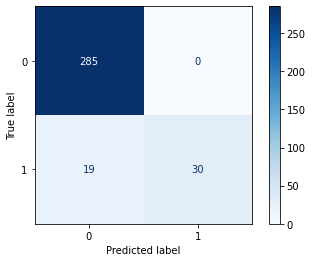

In [7]:
Xval = val_df.drop(['churn'], axis='columns')
yval = val_df['churn']
ev.BuildConfusion(clf, Xval, yval, cmap='Blues')

In [8]:
ev.AUC(clf, Xval, yval)

0.8061224489795918

In [9]:
cba = ev.BinaryCBA(clf, Xval, yval, 56, 350, 14)
print('this model would save ${} from prevented churn at the cost of losing ${}'.format(cba[1], cba[0]))

this model would save $11760 from prevented churn at the cost of losing $6650


# Step 2: normalize the data
Accuracy imporved more from MinMaxScaling but validation recall and AUC dropped significantly. I ended up using standard scaler instead.

In [10]:
scaler = StandardScaler()
ev.PipeIt(scaler, clf, X, y)

[18:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9991107158737217, Validation: 0.944'

In [11]:
scaler = MinMaxScaler()
ev.PipeIt(scaler, clf, X, y)

[18:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9991107158737217, Validation: 0.9546666666666667'

In [12]:
X2 = pd.DataFrame(StandardScaler().fit(X).transform(X))
X2.columns = list(X.columns)
Xval2 = pd.DataFrame(StandardScaler().fit(Xval).transform(Xval))
Xval2.columns = list(X.columns)

In [13]:
estimators = al.Estimators(X2, 100)
grid = {'learning_rate': [0.1, 0.2], 'max_depth': [3, 6, 9], 'min_child_weight': [1, 2], 
        'subsample': [0.5, 0.7, 1], 'n_estimators': estimators}
clf = ml.Optimize(XGBClassifier(), grid, X2, y)

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.4min


[18:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 1188 out of 1188 | elapsed:  1.7min finished


In [14]:
ev.ScoreModel(clf, X2, y)

[18:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 0.9919964428634949, Validation: 0.9573333333333334'

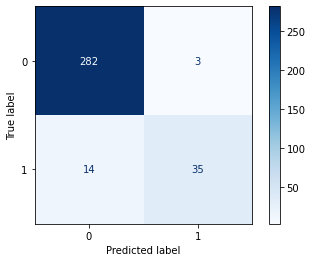

In [15]:
ev.BuildConfusion(clf, Xval2, yval, cmap='Blues')

In [16]:
cba = ev.BinaryCBA(clf, Xval2, yval, 56, 350, 14)
print('this model would save ${} from prevented churn at the cost of losing ${}'.format(cba[1], cba[0]))

this model would save $13720 from prevented churn at the cost of losing $4942


In [17]:
ev.AUC(clf, Xval2, yval)

0.8518796992481203

## Step 3: fixing class imbalance with SMOTE sampling

Smote, synthetic minority oversampling, handles class imbalance that generate synthetic datapoints of the minority class. this way the model isn't rewarded for simply labeling everything the majority class
* In addition to SMOTE, you can set metrics to 'recall', which I already did in cell 4

In [18]:
bool_arr = dh.GetCats(X) #returns an array of booleans, True indicating that the feature is categorical
X3, y3 = dh.SmoteIt(X2, y, bool_arr=bool_arr) #Because we have categorical features, SmoteIt will use SMOTENC

Using Smotenc


In [19]:
estimators = al.Estimators(X3, 100)
grid = {'learning_rate': [0.1, 0.2], 'max_depth': [3, 6, 9], 'min_child_weight': [1, 2], 
        'subsample': [0.5, 0.7, 1], 'n_estimators': estimators}
clf = ml.Optimize(XGBClassifier(), grid, X3, y3)

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1188 out of 1188 | elapsed:  4.8min finished


[18:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
ev.ScoreModel(clf, X3, y3)

[18:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'Training: 1.0, Validation: 0.9812938425565082'

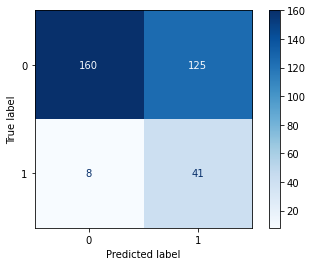

In [21]:
Xval2 = pd.DataFrame(Xval2)
Xval2.columns = list(X.columns)
ev.BuildConfusion(clf, Xval2, yval, cmap='Blues')

In [22]:
cba = ev.BinaryCBA(clf, Xval2, yval, 56, 350, 14)
print('this model would save ${} from prevented churn at the cost of losing ${}'.format(cba[1], cba[0]))

this model would save $16072 from prevented churn at the cost of losing $4550


In [23]:
ev.AUC(clf, Xval2, yval)

0.6990691013247404

## Step 4: Time for some Feature Engineering

[18:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


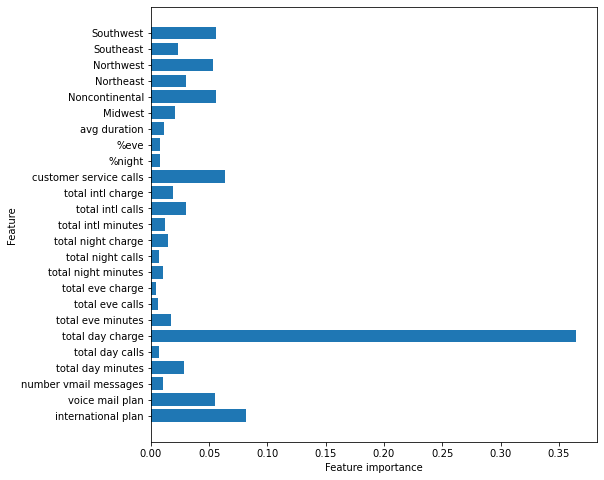

In [24]:
ev.GetImportance(clf, X3, y3)

In [25]:
X4, Xval4 = wr.FeatureEngineering(X3, y3, Xval2, yval, clf, 'classification', 'recall')

X4.head()

[18:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,international plan,voice mail plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southwest
0,-0.330299,-0.619630,-0.592383,0.698258,0.697878,0.578917,0.579221,0.128281,-1.010338,0.124967,-0.425476,-0.859266,1.771031,-0.178893,-0.601618,-0.345612,-0.351028
1,-0.330299,1.613867,1.671306,0.034077,0.033804,0.246259,0.245751,0.414289,-0.190975,0.416280,-0.425476,-0.066993,-0.564643,-0.178893,-0.601618,2.893419,-0.351028
2,-0.330299,-0.619630,-0.592383,-1.737070,-1.736700,-1.259560,-1.259494,1.415315,0.628388,1.409393,0.336772,1.089359,1.771031,-0.178893,-0.601618,-0.345612,-0.351028
3,-0.330299,1.613867,1.160150,-1.985909,-1.986401,-0.375753,-0.374873,0.950553,-1.420020,0.945940,-0.425476,1.318485,-0.564643,-0.178893,-0.601618,-0.345612,-0.351028
4,3.027557,1.613867,1.817350,0.442100,0.441720,-0.257649,-0.256769,0.092530,0.628388,0.098483,1.099020,0.944766,-0.564643,5.589930,-0.601618,-0.345612,-0.351028


In [26]:
X4.shape

(5130, 17)

In [27]:
estimators = al.Estimators(X4, 100)
grid = {'learning_rate': [0.1, 0.2], 'max_depth': [3, 6, 9], 
        'min_child_weight': [1, 2], 'subsample': [0.5, 0.7, 1], 
        'n_estimators': estimators}
clf = ml.Optimize(clf, grid, X4, y3)

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1188 out of 1188 | elapsed:  4.0min finished


[18:30:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


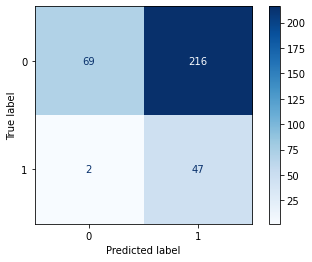

In [28]:
ev.BuildConfusion(clf, Xval4, yval)

In [29]:
ev.AUC(clf, Xval4, yval)

0.6006444683136412

In [30]:
cba = ev.BinaryCBA(clf, Xval4, yval, 56, 350, 14)
print('this model would save ${} from prevented churn at the cost of losing ${}'.format(cba[1], cba[0]))

this model would save $18424 from prevented churn at the cost of losing $3724


Despite it's lower overall accuracy, this model is the best one because it has the best cost to benefit. this is because each false positive is a 14 dollar loss while a false negative is a 350 dollar loss.

# Giving Deep Learning a shot!

In [31]:
train_data = np.array(X4)
test_data = np.array(Xval4)
train_labels = dl.MulticlassOutput(np.array(y3))
test_lables = dl.MulticlassOutput(np.array(yval))

In [32]:
early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
model = dl.FastNN('classification', 'binary_crossentropy', output_dim=2)
history = model.fit(train_data, train_labels, batch_size=32, epochs=150, validation_split=0.2, callbacks=early_stopping)

Epoch 1/150
129/129 [==============================] - 1s 8ms/step - loss: 0.6096 - accuracy: 0.6534 - val_loss: 0.5482 - val_accuracy: 0.8177
Epoch 2/150
129/129 [==============================] - 0s 1ms/step - loss: 0.3883 - accuracy: 0.8416 - val_loss: 0.3242 - val_accuracy: 0.8840
Epoch 3/150
129/129 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8632 - val_loss: 0.3918 - val_accuracy: 0.8353
Epoch 4/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2937 - accuracy: 0.8829 - val_loss: 0.3000 - val_accuracy: 0.8743
Epoch 5/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2815 - accuracy: 0.8890 - val_loss: 0.2820 - val_accuracy: 0.8752
Epoch 6/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2609 - accuracy: 0.8949 - val_loss: 0.2875 - val_accuracy: 0.8752
Epoch 7/150
129/129 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.9000 - val_loss: 0.3951 - val_accuracy: 0.8333

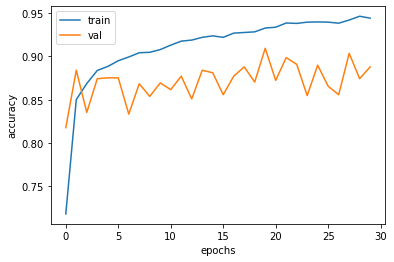

In [33]:
ev.ViewAccuracy(history)

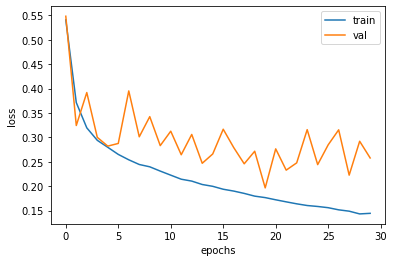

In [34]:
ev.ViewLoss(history)

<AxesSubplot:xlabel='Predict', ylabel='True'>

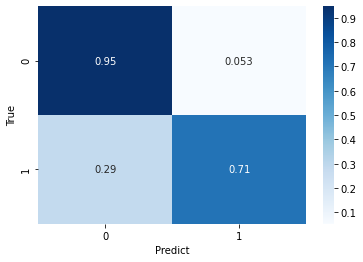

In [35]:
ev.BuildConfusionDL(model, test_data, test_lables, cmap='Blues')

Our training data has 71% recall and 95% precision, it's Ok but not our best.

here's the repo for this notebook: https://github.com/spe301/dsc-phase-3-project